In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
from sklearn import metrics
import sklearn.preprocessing as skp
import sklearn.metrics.pairwise as smp
from sklearn.cluster import KMeans
import sklearn.decomposition as skd
import sklearn.datasets as skds
from matplotlib import style
style.use("ggplot")
from collections import Counter
from pylab import *

In [2]:
import pandas as pd

class ProcessAmazon():
    """Read, filter, aggregate by ProductId, and generate X matrix"""

    def __init__(self, raw_data_filename, num_reviews_filter):
        """Initialize attributes."""
        self.raw_data_filename = raw_data_filename
        self.num_reviews_filter = num_reviews_filter
        self.raw_data = self.read_and_report()
        self.grouped_by_userid = self.group_by_userid()
        self.filtered = self.filter_()
        self.grouped_by_productid = self.group_by_productid()
        self.X = self.write_X()
    
    def read_and_report(self):
        """Read Amazon csv, report on file structure"""
        data = pd.read_csv(self.raw_data_filename)
        print(self.raw_data_filename, "has", data.shape[0], "rows and", data.shape[1], "columns. First five observations:")
        print(data.head(5))
        print(50 * '-')
        return data
    
    def group_by_userid(self):
        """Group by UserId and look at the distribution of number of reviews"""
        grouped_by_uid = self.raw_data.groupby('UserId').count()
        print('Distribution of number of reviews for each UserId:')
        print(grouped_by_uid['ProductId'].value_counts())
        print(50 * '-')
        return grouped_by_uid
    
    def filter_(self):
        """Filter out reviewers with fewer than x reviews"""
        filtered = self.grouped_by_userid[self.grouped_by_userid['Id'] > self.num_reviews_filter]
        # remove redundant columns
        filtered_final = filtered.drop(filtered.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], axis=1)
        # recreate UserId from index
        filtered_final['UserId'] = filtered_final.index
        # rename columns
        filtered_final.columns = ['num_reviews', 'UserId']
        # left merge filtered list with raw data
        filtered = pd.merge(filtered_final, self.raw_data, how='left', on='UserId')
        print("Filtered data has", filtered.shape[0], "rows and", filtered.shape[1], "columns. First five observations:")
        print(filtered.head(5))
        print(50 * '-')
        return filtered
    
    def group_by_productid(self):
        """Group by ProductId and create a column that lists each UserId (separated by spaces) who reviewed that product"""
        grouped_by_pid = self.filtered.groupby('ProductId')['UserId'].apply(lambda x: ' '.join(x)).reset_index()
        print("Data grouped by ProductId has", grouped_by_pid.shape[0], "rows and", grouped_by_pid.shape[1], "columns. First five observations:")
        print(grouped_by_pid.head(5))
        print(50 * '-')
        return grouped_by_pid
    
    def write_X(self):
        """use bag of words to create boolean X to represent reviews by UserId (one UserId per column)"""
        from sklearn.feature_extraction.text import CountVectorizer
        count = CountVectorizer()
        uidArray = self.grouped_by_productid.UserId.as_matrix()
        userFeatures = count.fit_transform(uidArray)
        print("Shape of final X matrix:", userFeatures.shape)
        return userFeatures

In [3]:
import pandas as pd
class ViewClusteringResults():
    """Merge cluster definitions to raw data and view samples of clustering results, showing review summaries and texts."""
    
    def __init__(self, data_instance, model_instance):
        """Initialize attributes"""
        self.data_instance = data_instance
        self.model_instance = model_instance
    
    def merge_labels(self):
        """Merge cluster labels to raw data (as structured in Amazon.csv)"""
        labels_tomerge = pd.DataFrame(self.model_instance.labels_)
        labelled_products = pd.concat([self.data_instance.grouped_by_productid, labels_tomerge], axis=1, ignore_index=True)
        labelled_products.columns = ['ProductId', 'UserIds', 'cluster']
        merged = pd.merge(labelled_products, self.data_instance.raw_data, how='left', on='ProductId')
        merged_lite = merged[['ProductId', 'cluster', 'Summary', 'Text']]
        return merged_lite

    def view_cluster_samples(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            print(50 * '-')
            print('cluster: ', i)
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster size: ', cluster.shape)
            print(cluster.sample(n_samples))

In [4]:
# process Amazon.csv, filtering out people who left 4 or fewer reviews
amazonData = ProcessAmazon('/Users/michelleponce/Dropbox/Amazon.csv', 5)

/Users/michelleponce/Dropbox/Amazon.csv has 455000 rows and 13 columns. First five observations:
   Unnamed: 0      Id   ProductId          UserId       ProfileName  \
0      138806  138807  B000E63LME  A1CQGW1AOD0LF2  Alena K. "Alena"   
1      469680  469681  B004ZIH4KM  A37S7U1OX2MCWI        Becky Cole   
2      238202  238203  B003ZXE9QA  A2OM6G73E64EQ9              jeff   
3      485307  485308  B001RVFERK  A25W349EE97NBK          Tangent4   
4      375283  375284  B000OQZNTS  A3CPPW0HUC07YS       Amy Nicolai   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       2      2  1294185600   
1                     0                       0      5  1349740800   
2                     0                       0      5  1329264000   
3                     1                       1      4  1248307200   
4                     0                       0      5  1333238400   

                     Summary  \
0           Not as pict

In [5]:
TSVD = skd.TruncatedSVD(n_components=3000)
new_amazonData=TSVD.fit_transform(amazonData.X)

In [6]:
print(amazonData.X.dtype)

int64


In [7]:
print(new_amazonData.dtype)
print(new_amazonData.shape)
print(new_amazonData.ndim)

float64
(28199, 3000)
2


In [8]:
VR = TSVD.explained_variance_ratio_
print(VR)
print(sum(VR))

[  2.17533368e-02   1.93539410e-02   1.72903718e-02 ...,   3.93910511e-05
   3.93452151e-05   3.92551339e-05]
0.901645531524


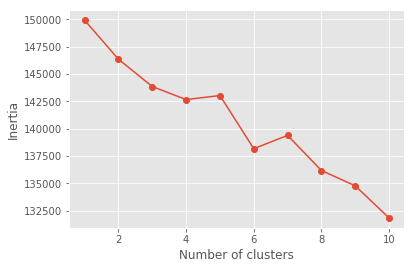

In [11]:
distortions = []

for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(new_amazonData)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [9]:
clusters_num = 10
km = KMeans(n_clusters=clusters_num, max_iter=500, n_init=15, random_state=1)
km.fit(new_amazonData)
#go look at max-iter and be more generous

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
    n_clusters=10, n_init=15, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [29]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(new_amazonData, km)

In [33]:
# view samples of product reviews, organized by KMeans cluster results
# viz.view_cluster_samples(7)
#error becauase "'numpy.ndarray' object has no attribute 'grouped_by_productid'

In [42]:
#WILL DO THIS PART DIFFERENTLY#

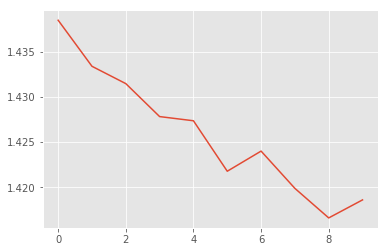

In [14]:
from scipy import cluster

initial = [cluster.vq.kmeans(new_amazonData,i) for i in range(1,11)]
plt.plot([var for (cent,var) in initial])
plt.show()

In [ ]:
# plt.figure()
# fig = plt.figure(figsize=(300,500))
# plt.subplot(1, 1, 1)

# cent, var = initial[6]
# assignment,cdist = cluster.vq.vq(new_amazonData,cent)
# plt.scatter(new_amazonData[:,0], new_amazonData[:,1], c=assignment)

# plt.show()

In [10]:
labels = km.fit_predict(new_amazonData)
centroids = km.cluster_centers_

In [ ]:
sample_sillhouetete = sk.metrics.silhouette_score(new_amazonData,labels)
print(sample_sillhouetete)

In [104]:
km = KMeans(n_clusters=clusters_num, max_iter=500, n_init=15, random_state=1)
cds = km.fit_transform(new_amazonData)



In [98]:
# color = ["g", "r", "b", "y", "m","k"]
# c = Counter(labels)
# for i in range(len(cds)):
#     print("coordinate:",cds[i], "label:", labels[i])
#     print ("i : ",i)
#     print ("color[labels[i]] : ",color[labels[i]])
# plt.scatter(cds[i][0], cds[i][1], c=color[labels[i]])

# for cluster_number in range(1,7):
#     print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))
# plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", linewidths = 5, zorder = 100)

# plt.show()


In [113]:
color = ["g", "r", "b", "y", "m","k"]
c= Counter(labels)

for i in range(new_amazonData.shape[0]):
    print("coordinate:",new_amazonData[i], "label:", labels[i])
    print ("i : ",i)
    print ("color[labels[i]] : ",color[labels[i]])
plt.scatter(new_amazonData[i][0], labels[i][1], c=color[labels[i]])

for cluster_number in range(clusters_num):
    print("Cluster {} contains {} samples".format(cluster_number, d[cluster_number]))
plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", linewidths = 5, zorder = 100)



coordinate: [  1.33915257e-05   5.04260861e-06   8.64251610e-07 ...,   7.61984406e-03
   1.84282332e-03   3.94401494e-03] label: 0
i :  0
color[labels[i]] :  g
coordinate: [ 0.0068229   0.00323464  0.00026463 ..., -0.00344959 -0.0034887
 -0.00136557] label: 0
i :  1
color[labels[i]] :  g
coordinate: [ 0.00933341  0.00414694  0.00035281 ...,  0.004699   -0.01083148 -0.010997  ] label: 0
i :  2
color[labels[i]] :  g
coordinate: [ 0.00383015  0.00139165  0.0001375  ..., -0.00048364  0.00128298
  0.00203589] label: 0
i :  3
color[labels[i]] :  g
coordinate: [  4.90391945e-05   6.09144810e-07   5.78631414e-07 ...,  -1.46974823e-02
   2.55118236e-04   3.24820126e-02] label: 0
i :  4
color[labels[i]] :  g
coordinate: [ 0.01404116  0.0033905   0.00038038 ...,  0.00219162 -0.00106634
 -0.00333246] label: 0
i :  5
color[labels[i]] :  g
coordinate: [ 0.01713925  0.00376925  0.00046307 ...,  0.02303992  0.01060681
 -0.01043604] label: 0
i :  6
color[labels[i]] :  g
coordinate: [  3.13310532e-03   

IndexError: invalid index to scalar variable.

In [ ]:
plt.show()